In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [2]:
import sqlite3
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [10]:
#!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [11]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4.1-mini",temperature=0)

class State(MessagesState):
    context: str

def call_model(state: State):
    context = state.get("context", "")
    if context:
        system_message = f"Context of the conversation had till now: {context}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def contexualize_conversation(state: State):
    context = state.get("context", "")
    if context:
        context_message = (
            f"This is context of the conversation to date: {context}\n\n"
            "Extend the context by taking into account the new messages above: "
        )     
    else:
        context_message = "Create context from the conversation above: "

    messages = state["messages"] + [HumanMessage(content=context_message)]
    response = model.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-3]]
    
    return {"context": response.content, "messages": delete_messages}

def should_continue(state: State):
    """Return the next node to execute."""
    
    messages = state["messages"]
    if len(messages) > 6:
        return "contexualize_conversation"

    return END

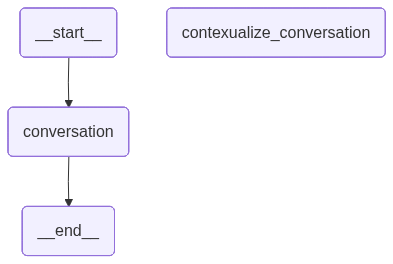

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(contexualize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("contexualize_conversation", END)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="Hi! I'm Daksh")
output = graph.invoke({"messages": [input_message]}, config) 

for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 

for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the Cules!")
output = graph.invoke({"messages": [input_message]}, config) 

for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Daksh! Nice to meet you again. How are you doing today? Would you like to chat more about FC Barcelona, the Cules, or anything else you're interested in?
================================== Ai Message ==================================

Your name is Daksh. How can I assist you today, Daksh?
================================== Ai Message ==================================

That's awesome, Daksh! The Cules are some of the most passionate and dedicated fans in football. Do you have a favorite FC Barcelona player or a memorable match you enjoyed?


In [16]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [AIMessage(content="Hi Daksh! Nice to meet you again. How are you doing today? Would you like to chat more about FC Barcelona, the Cules, or anything else you're interested in?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 289, 'total_tokens': 326, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CTaErnHaKCnIELl3LsJmaymFTu4jh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a636d648-bb9f-4065-99e5-3b331db3fc99-0', usage_metadata={'input_tokens': 289, 'output_tokens': 37, 'total_tokens': 326, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), Hum

In [17]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [AIMessage(content="Hi Daksh! Nice to meet you again. How are you doing today? Would you like to chat more about FC Barcelona, the Cules, or anything else you're interested in?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 289, 'total_tokens': 326, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CTaErnHaKCnIELl3LsJmaymFTu4jh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a636d648-bb9f-4065-99e5-3b331db3fc99-0', usage_metadata={'input_tokens': 289, 'output_tokens': 37, 'total_tokens': 326, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), Hum